# Sentiment Analysis With Custom Trained Word2Vec + Deep Learning

## Imports and Notebook Setup

In [55]:
import sys
import pickle
import dill
import numpy as np
import pandas as pd
import html.parser
import gensim
import matplotlib.pyplot as plt

from imblearn.over_sampling import SMOTE

from scipy import spatial

from sklearn.model_selection import train_test_split
from sklearn.utils import resample

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv1D, MaxPooling1D, Dropout, Activation, LSTM
from keras.layers.embeddings import Embedding
from keras.optimizers import Adam
from keras.initializers import Constant

In [4]:
sys.path.insert(0, '..')

%load_ext autoreload
%autoreload 2

In [11]:
from utils.text_processing import apply_regexes, unescape_html, remove_html_tags, remove_line_breaks, preprocess

In [12]:
pd.set_option('display.max_colwidth', None)

## Loading Data

In [13]:
df = pd.read_csv("../data/Reviews.csv")

# Introduction

## Custom Trained Word Embeddings

Previously, we talked about the idea of word embedding in our models in the [Sentiment Analysis Word Embedding notebook](SentimentAnalysisWordEmbedding.ipynb). Continuing our work, we can use our custom trained Word2Vec model, `review2vec`, generated in the [review2vec](../feature_engineering/review2vec.ipynb), as our main word embedding features. 

The benefit of this shines particularly when we consider the domain that we are working in. The type of words and their meanings used changes depending on the corpus the embeddings are trained on, and the difference in the embedded locations in the feature space can make a big impact on model performance.

We can take a look at an example we gave in the [review2vec notebook](../feature_engineering/review2vec.ipynb). For food reviews, customers may have concerns about the expiry date of the food that they are ordering. Using the pre-trained GloVe model, we can see the 10 closest words in the feature space to the word `expire`. To do this, we load the GloVe data and calculate the distance between embedded words.

In [49]:
embeddings_index = {}
with open('glove/glove.6B.300d.txt', encoding="utf8") as f:
    line = f.readline()
    while line:
        values = line.split()
        word = values[0]
        try:
           coefs = np.asarray(values[1:], dtype='float32')
           embeddings_index[word] = coefs
        except ValueError:
           pass
        line = f.readline()

In [58]:
def find_closest_embeddings(embedding):
    return sorted(embeddings_index.keys(), key=lambda word: spatial.distance.euclidean(embeddings_index[word], embedding))

In [59]:
find_closest_embeddings(embeddings_index["expire"])[0:10]

['expire',
 'expires',
 'expiring',
 'expired',
 'expiration',
 'renew',
 'expiry',
 'extend',
 'terminated',
 'extended']

Above shows the list of the 10 closest words to `expire` for the pre-trained GloVe model. We can compare that to the results we got when we trained the `review2vec` model on the review text:

```
[('expiration', 0.8689521551132202),
 ('expires', 0.8167486786842346),
 ('date', 0.8046296834945679),
 ('expired', 0.7890604734420776),
 ('expiring', 0.7793307900428772),
 ('exp', 0.7547811269760132),
 ('oct', 0.7090200185775757),
 ('august', 0.702245831489563),
 ('stale', 0.6954241991043091),
 ('expiry', 0.6935100555419922)]
 ```
 
There is a clear difference between how the word embeddings perform across these domains. In the pre-trained model, the word `expire` is related to terms like `renew`, `extend`, and `terminated`. These may be related to things like subscription services or contracts--things that generally require renewals. 

However, the similar words in the custom embedding model show different ideas. For the word `expire`, instead of finding similar terms like `renew`, which doesn't make sense in the context of food, we see words like `date` and `stale`. Being able to connect these words together with a custom embedding model will help the deep learning model group similar reviews and text together.

## Handling Class Imbalance

In addition to the vectorization of the text described above, another aspect we need to deal with is the class imbalance between reviews with positive sentiment vs. reviews with negative sentiment. With our comparison of the different sampling techniques in the [sampling notebook](../eda/sampling_and_class_balancing.ipynb) notebook, we will proceed with the SMOTE method of generating synthetic samples for our minority class. 

## Model Building

For the models we're using, we'll continue using the LSTM model. We'll explore using both the pre-trained `review2vec` model as well as using custom embedding generated by the embedding layer itself.

With these thoughts in mind, we proceed with our work.

# Text Cleanup

In [14]:
df['cleaned_text'] = df['Text'] + ' ' + df['Summary']
df['cleaned_text'].fillna("", inplace=True)

df['cleaned_text'] = df['cleaned_text'] \
    .apply(lambda x: unescape_html(remove_html_tags(remove_line_breaks(x), 'html.parser')))

In [15]:
df['preprocessed_text'] = df['cleaned_text'].apply(preprocess)

In [16]:
df.loc[df['Score'] <= 3, 'sentiment'] = 0
df.loc[df['Score'] > 3, 'sentiment'] = 1

# Word Embedding and Feature Engineering

We load the `review2vec` model we trained and double check the examples given above.

In [17]:
review2vec = gensim.models.Word2Vec.load("../model/review2vec.model")

In [18]:
review2vec.wv.most_similar('expired')

[('expiration', 0.8875916004180908),
 ('date', 0.8579495549201965),
 ('expires', 0.8161500096321106),
 ('expire', 0.7890604138374329),
 ('outdated', 0.7780749797821045),
 ('exp', 0.775046169757843),
 ('expiring', 0.7295963168144226),
 ('expiry', 0.7203924059867859),
 ('stale', 0.7186417579650879),
 ('oct', 0.695559024810791)]

In [19]:
review2vec.wv.similarity('taste', 'flavor')

0.81793463

## Standardizing Sequence Length

One thing we need to set is the length of our features (in particular, how many words we'll use in the review). First, we take a look at the distribution of the words in each review.

In [20]:
num_words_per_review = df['preprocessed_text'].str.split().str.len()

Text(0.5, 1.0, 'Number of Words Per Review')

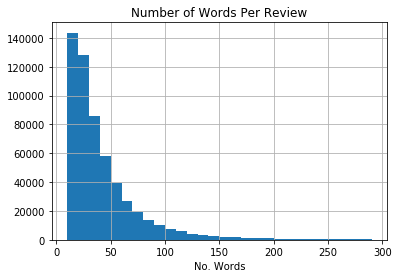

In [21]:
plt.hist(num_words_per_review, bins=[10 * i for i in range(1, 30)])
plt.grid(True)

plt.xlabel('No. Words')
plt.title('Number of Words Per Review')

We see that the majority of reviews are under 80 words. We'll use that as our max length.

In [22]:
MAX_SEQUENCE_LENGTH = 80

## Splitting Training/Testing Data

Now, we'll split our training and testing data. We give the test size 20% of the total samples. Keep in mind that we will still need to use a portion of the training data as our validation set.

In [23]:
X = df['preprocessed_text']
y = df['sentiment']

X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2, 
    random_state=1, 
    stratify=y
)

## Featurization

Now, we will vectorize the review text for each review. In this case, we'll take the top 10000 words in our training corpus for our tokenizer. Ideally, we'd be able to use a higher number, but unfortunately due to memory limitations we are forced to reduce the size. We can then create the embedding matrix that will be fed into the embedding layer of our model. We'll pad our sequences with the defined `MAX_SEQUENCE_LENGTH` here as well.

In [63]:
# Tokenizing the reviews words
k = 10000

tokenizer = Tokenizer(num_words=k)
tokenizer.fit_on_texts(X_train)

# Creating embedding matrix for directly feeding to Embedding() layer of Keras

num_words = len(tokenizer.word_index) + 1
embedding_matrix = np.zeros((num_words, 100)) # We trained review2vec with dim=100

for word, i in tokenizer.word_index.items():
    
    if i > num_words:
        continue
    
    if word in review2vec.wv.vocab:
        embedding_vector = review2vec.wv[word]
        embedding_matrix[i] = embedding_vector

In [25]:
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

X_train = pad_sequences(X_train, maxlen=MAX_SEQUENCE_LENGTH, padding='post')
X_test = pad_sequences(X_test, maxlen=MAX_SEQUENCE_LENGTH, padding='post')

## SMOTE Resampling

As mentioned in the introduction, we'll rebalance our training dataset with SMOTE. We'll also now split the training set and validation set. 

In [26]:
smote = SMOTE()

X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [32]:
# Saving the vectors
with open("../data/X_train_smote", 'wb') as f:
    dill.dump(X_train_smote, f)

with open("../data/y_train_smote", 'wb') as f:
    dill.dump(y_train_smote, f)

In [27]:
# Splitting the training and validation set data

X_train_sm, X_valid_sm, y_train_sm, y_valid_sm = train_test_split(
    X_train_smote, 
    y_train_smote, 
    test_size=0.2, 
    random_state=1, 
    stratify=y_train_smote
)

# Sentiment Analysis Models

## LSTM + Word2Vec Training

We define the same architecture of the LSTM model in the [Sentiment Analysis Word Embedding notebook](SentimentAnalysisWordEmbedding.ipynb) and train the model.

In [30]:
model_review2vec = Sequential()

adam = Adam(lr=1e-3, beta_1=0.9, beta_2=0.999)
loss = 'binary_crossentropy'

embedding_layer = Embedding(
    num_words,
    100, # Dimension of trained review2vec
    embeddings_initializer=Constant(embedding_matrix),
    input_length=MAX_PAD_LENGTH,
    trainable=False
)
model_review2vec.add(embedding_layer)
model_review2vec.add(Dropout(0.2))

model_review2vec.add(Conv1D(64, 5, activation='relu'))
model_review2vec.add(MaxPooling1D(pool_size=4))

model_review2vec.add(LSTM(100))
model_review2vec.add(Dropout(0.4))

model_review2vec.add(Dense(1, activation='sigmoid'))

model_review2vec.compile(loss=loss, optimizer=adam, metrics=['accuracy'])
model_review2vec.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 80, 100)           9485000   
_________________________________________________________________
dropout_1 (Dropout)          (None, 80, 100)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 76, 64)            32064     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 19, 64)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               66000     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                

In [33]:
model_review2vec_history = model_review2vec.fit(
    X_train_sm, 
    y_train_sm, 
    batch_size=32, 
    epochs=10, 
    validation_data=(X_valid_sm, y_valid_sm)
)

Train on 568033 samples, validate on 142009 samples
Epoch 1/10
568033/568033 [==============================] - 590s 1ms/step - loss: 0.2621 - accuracy: 0.8892 - val_loss: 0.2038 - val_accuracy: 0.9168
Epoch 2/10
568033/568033 [==============================] - 594s 1ms/step - loss: 0.2151 - accuracy: 0.9109 - val_loss: 0.1892 - val_accuracy: 0.9246
Epoch 3/10
568033/568033 [==============================] - 594s 1ms/step - loss: 0.1965 - accuracy: 0.9193 - val_loss: 0.1805 - val_accuracy: 0.9281
Epoch 4/10
568033/568033 [==============================] - 590s 1ms/step - loss: 0.1852 - accuracy: 0.9251 - val_loss: 0.1702 - val_accuracy: 0.9329
Epoch 5/10
568033/568033 [==============================] - 591s 1ms/step - loss: 0.1775 - accuracy: 0.9287 - val_loss: 0.1659 - val_accuracy: 0.9354
Epoch 6/10
568033/568033 [==============================] - 594s 1ms/step - loss: 0.1717 - accuracy: 0.9312 - val_loss: 0.1650 - val_accuracy: 0.9363
Epoch 7/10
568033/568033 [======================

In [39]:
with open("../model/lstm_review2vec_history.pkl", 'wb') as f:
    dill.dump(model_review2vec_history, f)

In [40]:
with open("../model/lstm_review2vec.pkl", 'wb') as f:
    dill.dump(model_review2vec, f)

### Plot Accuracy and Loss

In [34]:
val_accuracy = model_review2vec_history.history['val_accuracy']
val_loss = model_review2vec_history.history['val_loss']

train_accuracy = model_review2vec_history.history['accuracy']
train_loss = model_review2vec_history.history['loss']

epochs = range(1, len(train_accuracy) + 1)

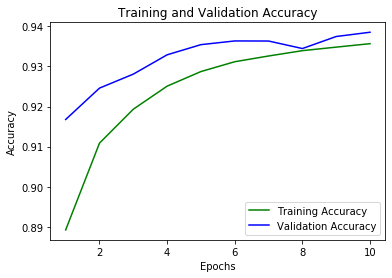

In [35]:
plt.plot(epochs, train_accuracy, 'g', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation Accuracy')

plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.legend()
plt.show()

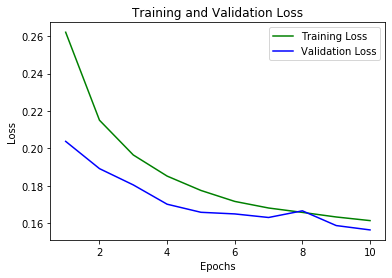

In [36]:
plt.plot(epochs, train_loss, 'g', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')

plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.legend()
plt.show()

### Evaluate Model

In [64]:
model_review2vec.evaluate(X_test, y_test)

177511/177511 [==============================] - 24s 137us/step


[0.1674115820749521, 0.9339928030967712]

## LSTM + Custom Word Embedding

We'll now apply the same neural net architecture, but instead let the model determine the embedding weights.

In [38]:
model_custom = Sequential()

adam = Adam(lr=1e-3, beta_1=0.9, beta_2=0.999)
loss = 'binary_crossentropy'

embedding_layer_custom = Embedding(
    num_words,
    100,
    input_length=MAX_PAD_LENGTH
)
model_custom.add(embedding_layer_custom)
model_custom.add(Dropout(0.2))

model_custom.add(Conv1D(64, 5, activation='relu'))
model_custom.add(MaxPooling1D(pool_size=4))

model_custom.add(LSTM(100))
model_custom.add(Dropout(0.4))

model_custom.add(Dense(1, activation='sigmoid'))

model_custom.compile(loss=loss, optimizer=adam, metrics=['accuracy'])
model_custom.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 80, 100)           9485000   
_________________________________________________________________
dropout_3 (Dropout)          (None, 80, 100)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 76, 64)            32064     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 19, 64)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               66000     
_________________________________________________________________
dropout_4 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                

In [ ]:
model_custom_history = model_custom.fit(
    X_train_sm, 
    y_train_sm, 
    batch_size=32, 
    epochs=10, 
    validation_data=(X_valid_sm, y_valid_sm)
)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 568033 samples, validate on 142009 samples
Epoch 1/10
568033/568033 [==============================] - 614s 1ms/step - loss: 0.2501 - accuracy: 0.8974 - val_loss: 0.1895 - val_accuracy: 0.9292
Epoch 2/10
568033/568033 [==============================] - 614s 1ms/step - loss: 0.1552 - accuracy: 0.9416 - val_loss: 0.1543 - val_accuracy: 0.9406
Epoch 3/10
568033/568033 [==============================] - 614s 1ms/step - loss: 0.1249 - accuracy: 0.9536 - val_loss: 0.1544 - val_accuracy: 0.9443
Epoch 4/10
568033/568033 [==============================] - 617s 1ms/step - loss: 0.1066 - accuracy: 0.9611 - val_loss: 0.1573 - val_accuracy: 0.9440
Epoch 5/10
568033/568033 [==============================] - 618s 1ms/step - loss: 0.0945 - accuracy: 0.9658 - val_loss: 0.1598 - val_accuracy: 0.9437
Epoch 6/10
568033/568033 [==============================] - 619s 1ms/step - loss: 0.0851 - accuracy: 0.9693 - val_loss: 0.1633 - val_accuracy: 0.9449
Epoch 7/10
568033/568033 [======================

In [46]:
with open("../model/lstm_custom.pkl", 'wb') as f:
    dill.dump(model_custom, f)

In [47]:
with open("../model/lstm_custom_history.pkl", 'wb') as f:
    dill.dump(model_custom_history, f)

### Plot Accuracy and Loss

In [42]:
val_accuracy_custom = model_custom_history.history['val_accuracy']
val_loss_custom = model_custom_history.history['val_loss']

train_accuracy_custom = model_custom_history.history['accuracy']
train_loss_custom = model_custom_history.history['loss']

epochs_custom = range(1, len(train_accuracy_custom) + 1)

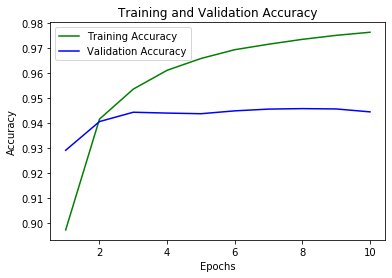

In [43]:
plt.plot(epochs_custom, train_accuracy_custom, 'g', label='Training Accuracy')
plt.plot(epochs_custom, val_accuracy_custom, 'b', label='Validation Accuracy')

plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.legend()
plt.show()

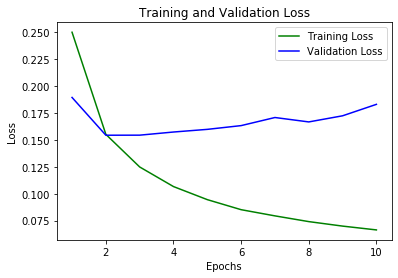

In [44]:
plt.plot(epochs, train_loss_custom, 'g', label='Training Loss')
plt.plot(epochs, val_loss_custom, 'b', label='Validation Loss')

plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.legend()
plt.show()

In [77]:
model_custom.evaluate(X_test, y_test)

177511/177511 [==============================] - 24s 137us/step


[0.19211047443615542, 0.9431697130203247]

# Conclusion

The combination of custom trained word embeddings and SMOTE yield very good results. They are substantially higher than the standard CNN/LSTM models and even higher than the ensemble method with Naive Bayes and Logistic Regression described in the [Review Extraction notebook](ReviewExtraction.ipynb). 